In [ ]:
pip install xgboost2sql

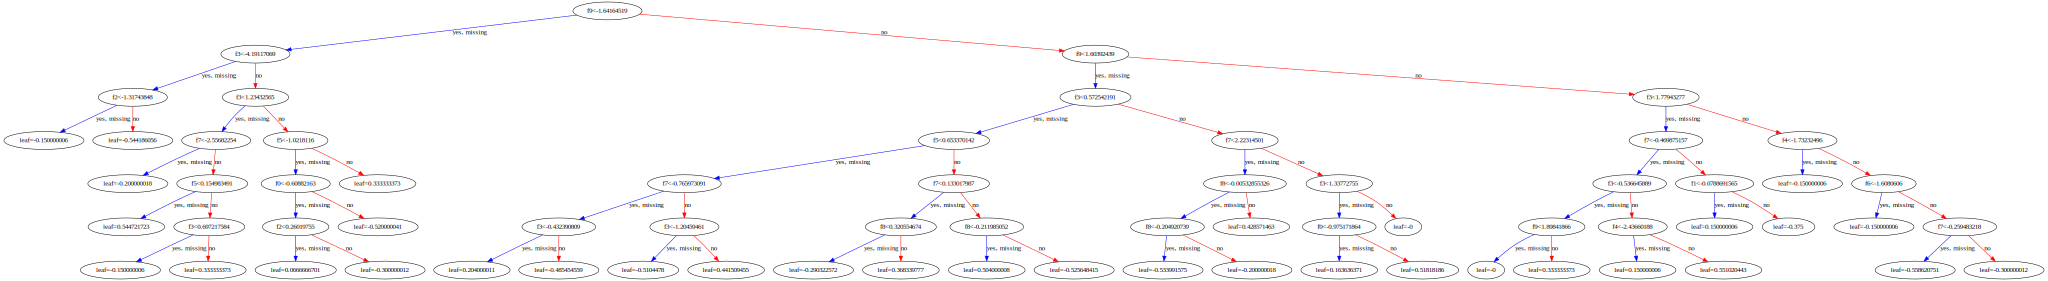

In [1]:
###训练1个xgboost二分类模型
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=2,
                           n_repeated=0,
                           n_classes=2,
                           weights=[0.7, 0.3],
                           flip_y=0.1,
                           random_state=1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1024)

###训练模型
model = xgb.XGBClassifier(n_estimators=3)
model.fit(X_train, y_train)
xgb.to_graphviz(model)

In [2]:
import pandas as pd
pd.set_option('display.float_format',lambda x : '%.9f' % x)
###使用模型对测试数据集进行预测
test_pred = model.predict_proba(X_test)[:, 1]
test_pred = pd.DataFrame(test_pred,columns=['python_pred_res'])
test_pred.reset_index(inplace=True)
test_pred.rename(columns={'index':'key'}, inplace=True)
print(test_pred)

       key  python_pred_res
0        0      0.788244247
1        1      0.220293656
2        2      0.220293656
3        3      0.790651679
4        4      0.220293656
...    ...              ...
2495  2495      0.220293656
2496  2496      0.220293656
2497  2497      0.217607751
2498  2498      0.220293656
2499  2499      0.762217879

[2500 rows x 2 columns]


In [3]:
from xgboost2sql import XGBoost2Sql
###使用xgboost2sql包将模型转换成的sql语句
xgb2sql = XGBoost2Sql()
sql_str = xgb2sql.transform(model)
print(sql_str)


    select key,1 / (1 + exp(-((tree_1_score + tree_2_score + tree_3_score)+(-0.0)))) as score
    from (
    select key,
    --tree1
		case when (f9<-1.64164519 or f9 is null) then
			case when (f3<-4.19117069 or f3 is null) then
				case when (f2<-1.31743848 or f2 is null) then
					-0.150000006
				else
					-0.544186056
				end
			else
				case when (f3<1.23432565 or f3 is null) then
					case when (f7<-2.55682254 or f7 is null) then
						-0.200000018
					else
						case when (f5<0.154983491 or f5 is null) then
							0.544721723
						else
							case when (f3<0.697217584 or f3 is null) then
								-0.150000006
							else
								0.333333373
							end
						end
					end
				else
					case when (f5<-1.0218116 or f5 is null) then
						case when (f0<-0.60882163 or f0 is null) then
							case when (f2<0.26019755 or f2 is null) then
								0.0666666701
							else
								-0.300000012
							end
						else
							-0.520000041
						end
					else
						0.333333373
					end
				e

In [4]:
###使用模型转换成的sql语句对测试数据集进行预测
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

X_test_df = pd.DataFrame(X_test)
X_test_df.columns = X_test_df.columns.map(lambda x: "f"+str(x))
X_test_df.reset_index(inplace=True)
X_test_df.rename(columns={'index':'key'}, inplace=True)
values = X_test_df.values.tolist()
columns = X_test_df.columns.tolist()
spark_df = spark.createDataFrame(values, columns)
spark_df.createOrReplaceTempView('data_table')
sql_pred_pysdf = spark.sql(sql_str)
sql_pred_df = sql_pred_pysdf.toPandas()
sql_pred_df.head(2)

,key,score
0,0.000000000,0.788244248
1,1.000000000,0.220293659


In [5]:
###对比python模型预测出来的结果和sql语句预测出来的结果是否一致
test_pred_sql_pred_df = test_pred.merge(sql_pred_df, on='key')
test_pred_sql_pred_df['diff'] = test_pred_sql_pred_df['python_pred_res'] - test_pred_sql_pred_df['score']
test_pred_sql_pred_df['diff'].describe()

count   2500.000000000
mean      -0.000000003
std        0.000000011
min       -0.000000068
25%       -0.000000003
50%       -0.000000001
75%       -0.000000000
max        0.000000056
Name: diff, dtype: float64

In [6]:
###可以看出差异只有小数位级别，说明sql_str这个语句就是1个模型了。可以放到大数据环境中进行分布式执行，能比单机的python预测快好几个量级
print(sql_str)


    select key,1 / (1 + exp(-((tree_1_score + tree_2_score + tree_3_score)+(-0.0)))) as score
    from (
    select key,
    --tree1
		case when (f9<-1.64164519 or f9 is null) then
			case when (f3<-4.19117069 or f3 is null) then
				case when (f2<-1.31743848 or f2 is null) then
					-0.150000006
				else
					-0.544186056
				end
			else
				case when (f3<1.23432565 or f3 is null) then
					case when (f7<-2.55682254 or f7 is null) then
						-0.200000018
					else
						case when (f5<0.154983491 or f5 is null) then
							0.544721723
						else
							case when (f3<0.697217584 or f3 is null) then
								-0.150000006
							else
								0.333333373
							end
						end
					end
				else
					case when (f5<-1.0218116 or f5 is null) then
						case when (f0<-0.60882163 or f0 is null) then
							case when (f2<0.26019755 or f2 is null) then
								0.0666666701
							else
								-0.300000012
							end
						else
							-0.520000041
						end
					else
						0.333333373
					end
				e

In [7]:
###将sql保存
xgb2sql.save()